<a href="https://colab.research.google.com/github/keim-hs-esslingen/MicroChargeNet/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sumolib
!pip install pyproj
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 144 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.7 MB/s 


[3111.56   871.305]
[8111.56  5871.305]


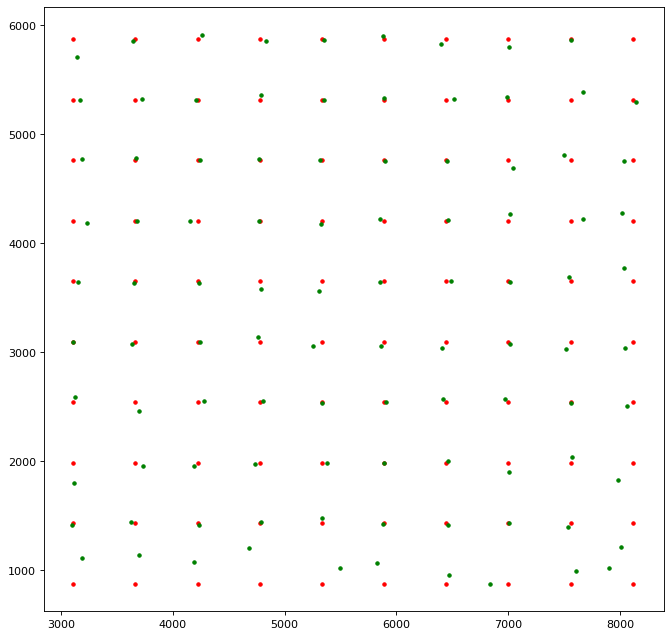

Min =369.44
Max = 1236.98
Durchschnitt = 645.3486734693878
Soll = 500
Abweichung = 29.06973469387756%


In [3]:
import sumolib
import pyproj
import numpy as np
import math

import matplotlib.pyplot as plt
# parse the net

#Berlin:      drive/MyDrive/Colab Notebooks/Berlin/berlin...
#Geislingen:  drive/MyDrive/Colab Notebooks/Geislingen/geislingen...
#Stuttgart:   drive/MyDrive/Colab Notebooks/Stuttgart/stuttgart...
net = sumolib.net.readNet('drive/MyDrive/Colab Notebooks/Berlin/berlin.net.xml.gz')

x0, y0, x1, y1 = net.getBoundary()

estimatetX = 5000
estimatetY = 5000
distance = 500


# create Mesh
countX= round(estimatetX / distance)
countY = round(estimatetY / distance)

xs = np. linspace(x0 + (x1-estimatetX)/2, x1 - (x1-estimatetX)/2, countX)
ys = np. linspace(y0 + (y1-estimatetY)/2, y1 - (y1-estimatetY)/2, countY)
X, Y = np. meshgrid(xs, ys)

# parse Coordinates 
rawPoints = np.append(X.reshape(-1,1),Y.reshape(-1,1),axis=1)

print(rawPoints[0])
print(rawPoints[-1])

#landuse
"""
polys = []

for poly in sumolib.shapes.polygon.read('drive/MyDrive/Colab Notebooks/Stuttgart/stuttgart.poly.xml'):
  if poly.type.startswith('landuse.industrial'):
    polys.append(poly)

print(polys[0])
print(sumolib.geomhelper.isWithin((4070, 2440), polys[0].shape))

###
"""


allowedEdgeTypes = {"highway.primary", "highway.primary_link", "highway.secondary", "highway.secondary_link",
                       "highway.tertiary", "highway.tertiary_link", "highway.unclassified", "highway.residential",
                       "highway.living_street", "highway.cycleway" }
allowedVehicleClasses = set(['private', 'bicycle', 'moped', 'motorcycle', 'evehicle'])

stations = []
lanesForStations = []

for i, point in enumerate(rawPoints):     

  # find nearest Edge
  #radius = (math.sqrt(2) * (xs[1] - xs[0])) / 2
  radius = (xs[1] - xs[0]) / 2
  lanes = net.getNeighboringLanes(point[0], point[1], radius, includeJunctions=False)

  # pick the closest edge
  nearestLane = None
  if len(lanes) > 0:
    clearedLanes = []

    for e in lanes:
      if e[0].getEdge().getType() in allowedEdgeTypes:
        if (e[0]._allowed & allowedVehicleClasses):
          clearedLanes.append(e)

    laneAndDistance = sorted(clearedLanes, key=lambda x: x[1] )
    if len(laneAndDistance) > 0:
      nearestLane = laneAndDistance[0]
      xy = sumolib.geomhelper.positionAtShapeOffset(nearestLane[0].getShape(), nearestLane[0].getLength()/2)
      poi = sumolib.shapes.poi.PoI('poi_'+str(i), 'station', '4', sumolib.color.decodeXML('red'), xy[0], xy[1] )
      stations.append(poi)
      lanesForStations.append(nearestLane[0]);
     



sx = [s.x for s in stations]
sy = [s.y for s in stations]

plt.figure(figsize=(10,10), dpi=80)

plt.plot(X, Y, '.', color='red')
plt.plot(sx, sy, '.', color='green')
plt.show()


# Create Poly File
with open('drive/MyDrive/Colab Notebooks/Berlin/berlin.stations.xml', 'w') as f:
  f.write('<?xml version="1.0"?>\n')
  f.write('<additional>\n')
  for poi in stations:
    f.write(poi.toXML())
  
  f.write('</additional>\n')


# Check avg distance
allDistances = []

for index, l1 in enumerate(lanesForStations):
 
#index = 2
#l1 = lanesForStations[index]
  distances = []
  for i in range(index-2*countX,index+2*countX):
    l2 = lanesForStations[i % len(lanesForStations)]
    if l1 != l2:
      distances.append(net.getShortestPath(l1._edge, l2._edge)) 

  shortest= sorted(distances, key=lambda x: x[1] )[0][1]
  if (shortest != float('inf')):
    allDistances.append(shortest)

mean = np.mean(allDistances)
print("Min =" + str(min(allDistances)))
print("Max = " + str(max(allDistances)))
print("Durchschnitt = "+str(mean))
print("Soll = " + str(distance))
print("Abweichung = "+ str(abs(mean-distance)*100/distance) + "%")
